In [1]:
%matplotlib widget
import numpy as np
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

# Load and reduce

In [5]:
pgroup = 'p21992'

runlist = np.arange(45, 48)
#runlist = [45, 46]

##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print ("will reduce {} run(s): {}".format(len(jsonlist), runlist))
jsonlist

will reduce 3 run(s): [45 46 47]


['/sf/alvra/data/p21992/raw/run0045-FePhen_Timescan_7119p5eV_001/meta/scan.json',
 '/sf/alvra/data/p21992/raw/run0046-FePhen_Timescan_7119p5eV_002/meta/scan.json',
 '/sf/alvra/data/p21992/raw/run0047-FePhen_Timescan_7119p5eV_003/meta/scan.json']

In [6]:
channel_diode_1 = 'SARES12-GES1:PR1_CH1_VAL_GET'
channel_diode_2 = 'SARES12-GES1:PR1_CH2_VAL_GET'

/sf/alvra/data/p21992/raw/run0047-FePhen_Timescan_7119p5eV_003/meta/scan.json
Step 111 of 111: Processing acq0111

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet           1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-CVME-EVR0:DUMMY_PV3_NBS    981 / 1003 -> 2% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude 1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position  1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET      1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET      1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAT-L-BECKBS:PR1_CH1_VAL_GET    1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 979 / 1003 -> 2% loss
complete channels: 0 / 8 -> 100% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1

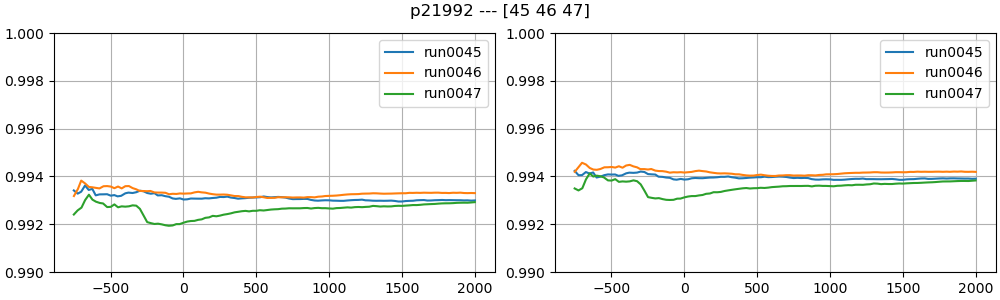

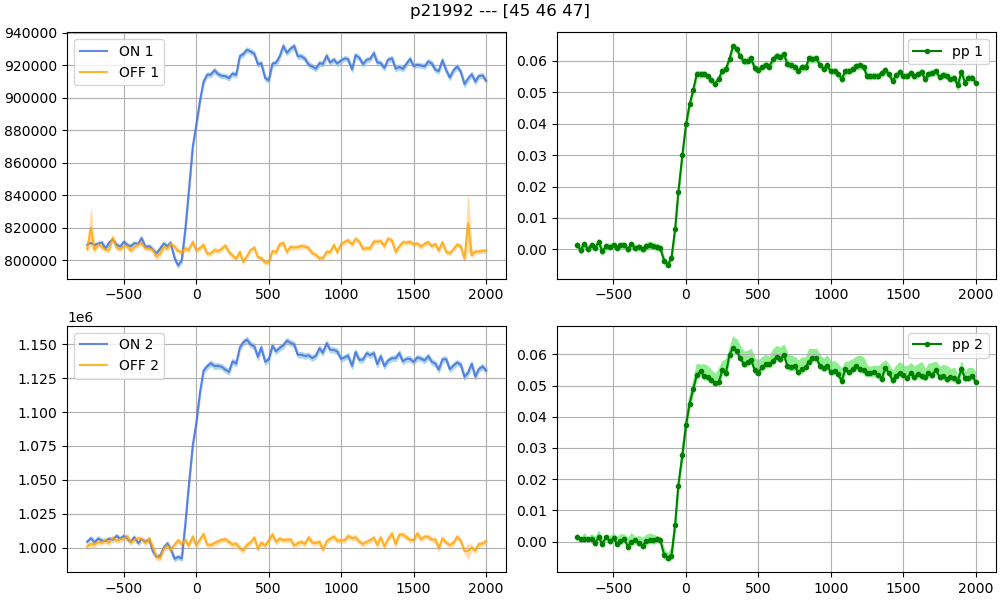

In [7]:
TT = TT_PSEN126

channel_delay_motor = channel_delay_beckhoff
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

reducedir='../Reduced_data/All_shots/'
saveflag = True

pump_1, unpump_1, pump_2, unpump_2, Izero_pump, Izero_unpump, Delays_stage, arrTimes, Delays_corr, energy, readbacks, corr1, corr2 = \
XAS_scanPP(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero)

Plot_correlations(pgroup, reducedir, runlist, timescan=True)
Plot_rawdata_2diodes(pgroup, reducedir, runlist, timescan=True)

# Plots the run(s)

[79]
1 scan(s), 27485 total on/off shots


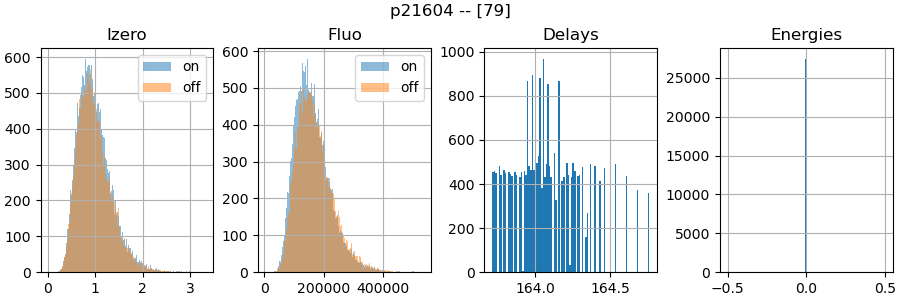

Time delay axis rebinned with delay stage data


In [10]:
twodiodes = False
withTT    = False

##############################################
data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, reducedir, runlist, twodiodes)

globals().update(data)
print (runlist)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(pump_1)))

Plot_XAS_scan(pgroup, runlist, data, withTT)

pump_1       = np.asarray(pump_1)
unpump_1     = np.asarray(unpump_1)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
energy       = np.asarray(energy)
Delays_corr  = np.asarray(Delays_corr)

Time delay axis rebinned with TT data
16092 shots out of 32912 survived (total shots: 39414)


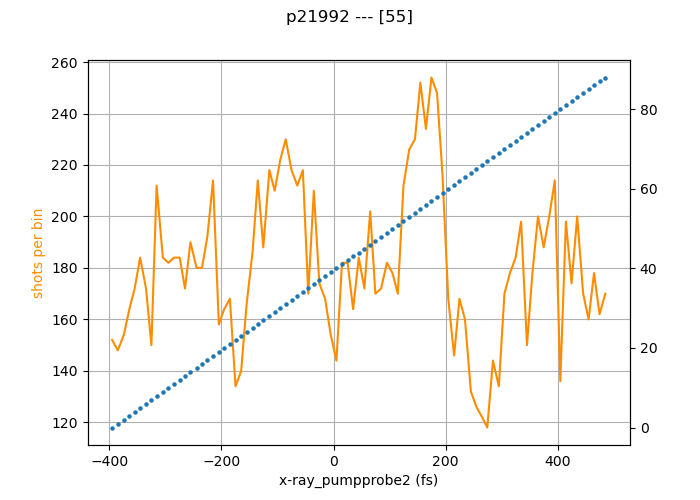

In [33]:
quantile = 0.7

binsize = 10
min_delay = -400
max_delay = 500

variable_bins=False
numbins=100

####################################################################
####################################################################

pp_TT, err_pp, Delay_fs_TT, howmany = rebin_and_filter_XAS(data, binsize, min_delay, max_delay, quantile, withTT, numbins, variable_bins)

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(Delay_fs_TT), 1)
ax1.plot(Delay_fs_TT, howmany, color = 'darkorange')
ax2.scatter(Delay_fs_TT, delayrange, s = 5)

ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()


Width = 176.2827 fs
t0 = -60.6047 fs


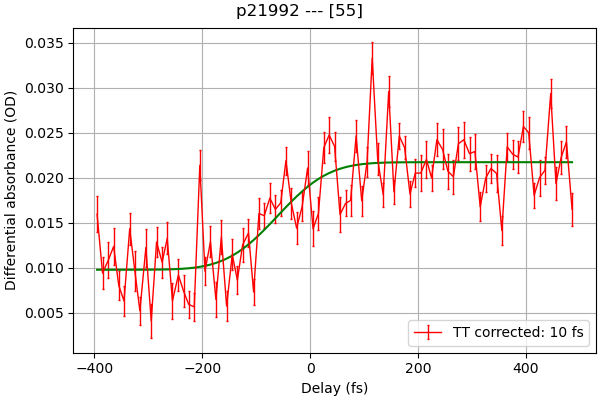

In [34]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(6,4))
plt.suptitle(titlestring_stack)

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected: {} fs'.format(binsize))
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    #fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,0)

    #p0 = [-100, 100, 0, 200, 0]
    #popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    #pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    # t0_fs = popt[0]
    # width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))
    print("t0 = {:.4f} fs".format(t0_fs))
plt.grid()
plt.ylabel('Differential absorbance (OD)')
plt.xlabel('Delay (fs)')
plt.show()

# FFT

43
(46,) (46,)


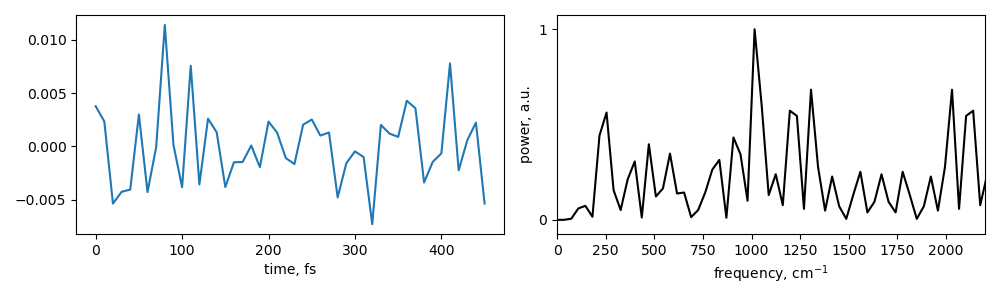

In [54]:
chosen_point = 30
index_point = np.int(np.argwhere(Delay_fs_TT > chosen_point)[0])
print (index_point)

transient = pp_TT[index_point:]
x = Delay_fs_TT[index_point:]
fit = pp_fit[index_point:]

print(np.shape(transient), np.shape(x))
fitoutput = np.poly1d(np.polyfit(x, transient, 3))
pows = fitoutput(x)
transient2 = transient-pows
#transient2 = transient-fit

                
vals = np.hstack((transient2, np.zeros_like(transient2))) # pad
power = np.abs(np.fft.fft(vals))**2
frequencies = np.arange(0,0.999999999,1/len(vals))*16678*(2/binsize)

plt.figure(figsize=(10,3))
#plt.suptitle(titlestring_stack)
plt.subplot(121)
#plt.plot(np.arange(0, binsize*len(transient), binsize), transient)
plt.plot(np.arange(0, binsize*len(transient), binsize), transient2, '-')
plt.xlabel('time, fs')

plt.subplot(122)
plt.plot(frequencies,power/np.max(power), '-', color='black')
plt.xlim(0,2200)
plt.xlabel('frequency, cm$^{-1}$')
plt.ylabel('power, a.u.')
plt.yticks([0,1])
plt.ylim(-0.075, 1.075)
#plt.vlines(1647, -0.1, 1.1, color='lightgrey', linestyle='dashed')
plt.tight_layout()

plt.show()
PNG_dir = '/sf/alvra/data/p21992/work/PNG/'
os.makedirs(PNG_dir, exist_ok=True)
plt.savefig(PNG_dir+'FePhen_XANES_FFT.png')

# Reduce:

* [Single run](#single_run)
* [Multiple runs](#multiple_runs)

<a id='single_run'></a>
## Reduce single run

In [14]:
pgroup='p21992'
runnumber = 177

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0177


'/sf/alvra/data/p21992/raw/run0177-MbCO_30um_timescan_7111.7eV_glass0_002/meta/scan.json'

In [15]:
channel_diode_1 = 'SARES12-GES1:PR1_CH1_VAL_GET'
channel_diode_2 = 'SARES12-GES1:PR1_CH2_VAL_GET'

In [16]:
with_TT    = True
Two_diodes = True

reducedir='../Reduced_data/Timescans/'
#reducedir='/sf/alvra/data/p21533/work/Reduced_data/Timescans_XANES/'
saveflag = True

t0_offset = 0         # in fs

quantile_corr = 0.7

channel_delay_motor = channel_delay_beckhoff
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

TT = TT_PSEN126

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

# scan.readbacks = scan.readbacks[1:]
# scan.files = scan.files[1:]

LoadTimescansXANES(with_TT, Two_diodes, scan, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero, 
                   quantile_corr, saveflag, reducedir, run_name, t0_offset)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)

Processing: run0177-MbCO_30um_timescan_7111.7eV_glass0_002
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1911 / 2003 -> 5% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1911 / 2003 -> 5% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1911 / 2003 -> 5% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1911 / 2003 -> 5% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1911 / 2003 -> 5% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1911 / 2003 -> 5% loss ▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET             2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET             2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY                2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAT-L-BECKBS:PR1_CH1_VAL_GET           2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over

# Plot the run

* [with TT](#TT)
* [without TT](#no_TT)

In [ ]:
pgroup = 'p21992'

# runlist1 = np.arange(85, 90, 1)
# runlist2 = np.arange(99, 103, 1)
# runlist3 = np.arange(106, 111, 1)
# runlist4 = np.arange(113, 116, 1)
# runlist = np.concatenate((runlist1, runlist2, runlist3, runlist4))
runlist = np.arange(45, 48)
##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print (len(jsonlist))
jsonlist

In [3]:
channel_diode_1 = 'SARES12-GES1:PR1_CH1_VAL_GET'
channel_diode_2 = 'SARES12-GES1:PR1_CH2_VAL_GET'

In [4]:
TT = TT_PSEN126

channel_delay_motor = channel_delay_beckhoff
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

reducedir='../Reduced_data/All_shots/'
saveflag = True

pump_1, unpump_1, Izero_pump, Izero_unpump, Delays_stage, arrTimes, Delays_corr, Energy = \
Reduce_XAS_scanPP(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero)



/sf/alvra/data/p21992/raw/run0047-FePhen_Timescan_7119p5eV_003/meta/scan.json
Step 111 of 111: Processing acq0111

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet           1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-CVME-EVR0:DUMMY_PV3_NBS    981 / 1003 -> 2% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude 1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position  1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET      1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET      1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAT-L-BECKBS:PR1_CH1_VAL_GET    1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 979 / 1003 -> 2% loss
complete channels: 0 / 8 -> 100% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1

[45, 46, 47]
3 scan(s), 320444 total on/off shots


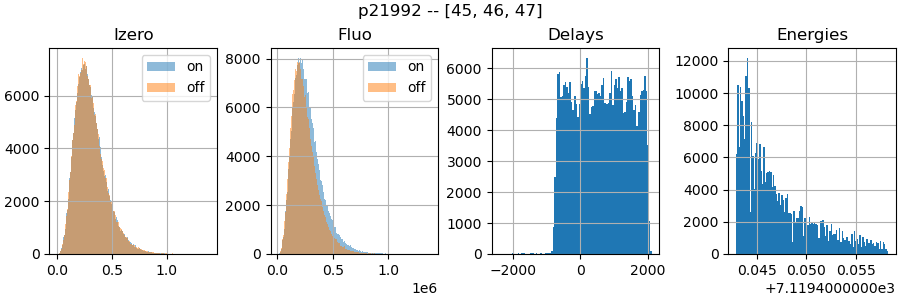

In [5]:
pgroup = 'p21992'
Loaddir_name = 'All_shots'

twodiodes = True
withTT    = True

runlist = [45,46,47]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist, twodiodes)

globals().update(data)
print (runlist)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(pump_1)))
Plot_XAS_scan(pgroup, runlist, data, withTT)
pump_1       = np.asarray(pump_1)
unpump_1     = np.asarray(unpump_1)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
energy       = np.asarray(energy)
Delays_corr  = np.asarray(Delays_corr)

138766 shots out of 286104 survived (48.50%, total shots: 320444)


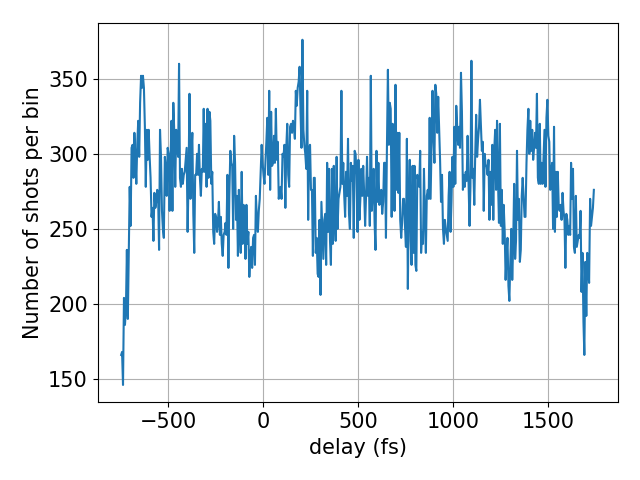

In [21]:
quantile = 0.7

#variable_bins = False
#withTT = True

numbins = 100

binsize = 5
min_delay = -750
max_delay = 1750

################################################################
binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
pp_TT = np.zeros(len(bin_centres))
err_pp = np.zeros(len(bin_centres))

totalshots = len(pump_1)
howmany_before = []
howmany = []
for i in range(len(bin_centres)):
    cond1 = Delays_corr >= binList[i]
    cond2 = Delays_corr < binList[i+1]

    idx = np.where(cond1*cond2)[0]
    Delay_fs_TT[i] = np.average(Delays_corr[idx])

    Fluo_pump_in_bin       = pump_1[idx]
    Fluo_unpump_in_bin     = unpump_1[idx]
    
    IzeroFEL_pump_in_bin   = Izero_pump[idx]
    IzeroFEL_unpump_in_bin = Izero_unpump[idx]
    
    howmany_before.append(len(Delays_corr[idx]))

    Fluo_pump_in_bin_filter, Fluo_unpump_in_bin_filter, IzeroFEL_pump_in_bin_filter, IzeroFEL_unpump_in_bin_filter = \
    correlation_filter(Fluo_pump_in_bin, Fluo_unpump_in_bin, IzeroFEL_pump_in_bin, IzeroFEL_unpump_in_bin, quantile)
    
    howmany.append(len(Fluo_pump_in_bin_filter))
    
    Fluo_pump_in_bin_filter   = Fluo_pump_in_bin_filter / IzeroFEL_pump_in_bin_filter
    Fluo_unpump_in_bin_filter = Fluo_unpump_in_bin_filter / IzeroFEL_unpump_in_bin_filter
    
    #Pump_probe_shot = Fluo_pump_in_bin_filter - Fluo_unpump_in_bin_filter
    Pump_probe_shot = np.log10(Fluo_pump_in_bin_filter / Fluo_unpump_in_bin_filter)

    pp_TT[i]  = np.nanmean(Pump_probe_shot)
    err_pp[i] = np.nanstd(Pump_probe_shot)/np.sqrt(len(Pump_probe_shot))

print ('{} shots out of {} survived ({:.2f}%, total shots: {})'.format(np.sum(howmany), np.sum(howmany_before), 100*np.sum(howmany)/np.sum(howmany_before), totalshots))
plt.figure()
plt.plot(Delay_fs_TT, howmany)
plt.xlabel('delay (fs)')
plt.ylabel('Number of shots per bin')
plt.tight_layout()
plt.grid()
plt.show()

Width = 96.1751 fs
t0 = -11.8564 fs


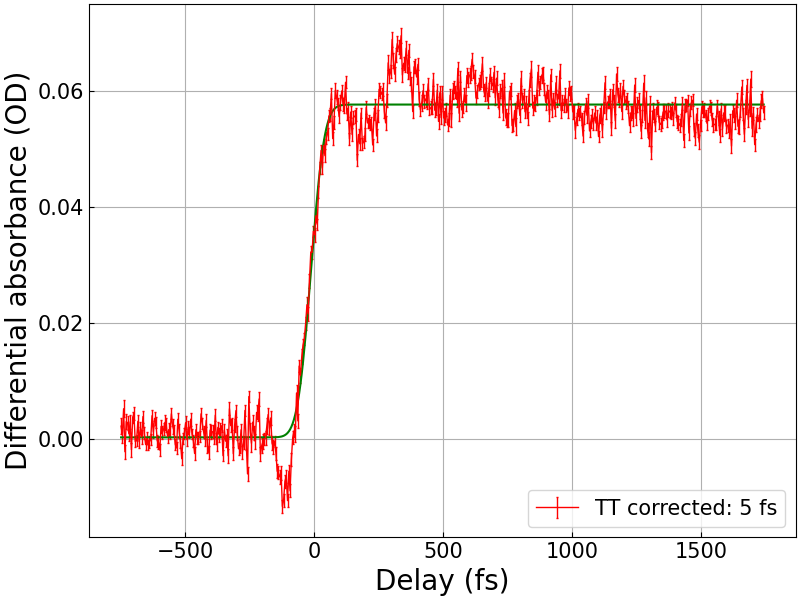

In [22]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(8,6))
plt.rcParams.update({'font.size': 15})
#plt.suptitle(runlist)
#plt.title('E = 7111.7 eV')
#units = scan.parameters['units'][0]
#label = scan.parameters['name'][0]

plt.tick_params(direction='in')

#plt.scatter(Delays_corr_scan, Pump_probe_scan, s=0.2, color = 'lightblue')

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected: {} fs'.format(binsize))

# plt.plot(Delay_fs_TT, pp_TT, 
#               lw=1,color='red',label='TT corrected: {} fs'.format(binsize))

# plt.xlabel("{} ({})".format(label, units))
# plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    #fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,0)

    #p0 = [-100, 100, 0, 200, 0]
    #popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    #pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    # t0_fs = popt[0]
    # width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))
    print("t0 = {:.4f} fs".format(t0_fs))

#plt.xlim(min_delay, max_delay)
plt.grid()
#plt.axvline(t0_fs)
#plt.tight_layout()
plt.ylabel('Differential absorbance (OD)', fontsize=20)
plt.xlabel('Delay (fs)', fontsize=20)
plt.show()

PNG_dir = '/sf/alvra/data/p21992/work/PNG/'
os.makedirs(PNG_dir, exist_ok=True)
#plt.savefig(PNG_dir+'FePhen_XANES_kinetics.png')

156
(343,) (343,)


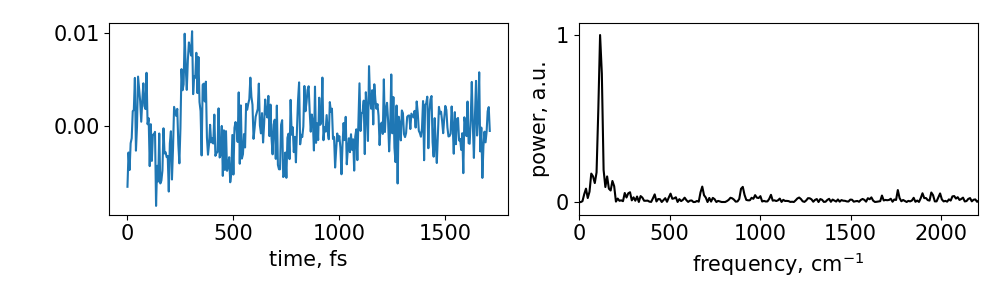

In [23]:
chosen_point = 30
index_point = np.int(np.argwhere(Delay_fs_TT > chosen_point)[0])
print (index_point)

transient = pp_TT[index_point:]
x = Delay_fs_TT[index_point:]
pp_fit = pp_fit[index_point:]

print(np.shape(transient), np.shape(x))
fitoutput = np.poly1d(np.polyfit(x, transient, 3))
pows = fitoutput(x)
transient2 = transient-pows
#transient2 = transient-pp_fit

                
vals = np.hstack((transient2, np.zeros_like(transient2))) # pad
power = np.abs(np.fft.fft(vals))**2
frequencies = np.arange(0,0.999999999,1/len(vals))*16678*(2/binsize)

plt.figure(figsize=(10,3))
#plt.suptitle(titlestring_stack)
plt.subplot(121)
#plt.plot(np.arange(0, binsize*len(transient), binsize), transient)
plt.plot(np.arange(0, binsize*len(transient), binsize), transient2, '-')
plt.xlabel('time, fs')

plt.subplot(122)
plt.plot(frequencies,power/np.max(power), '-', color='black')
plt.xlim(0,2200)
plt.xlabel('frequency, cm$^{-1}$')
plt.ylabel('power, a.u.')
plt.yticks([0,1])
plt.ylim(-0.075, 1.075)
#plt.vlines(1647, -0.1, 1.1, color='lightgrey', linestyle='dashed')
plt.tight_layout()

plt.show()
PNG_dir = '/sf/alvra/data/p21992/work/PNG/'
os.makedirs(PNG_dir, exist_ok=True)
plt.savefig(PNG_dir+'FePhen_XANES_FFT.png')

In [4]:
quantile = 0.7

#######################################################################################

Energy_set = scan.values

stepsize_energy = (Energy_set[-1]-Energy_set[0])/(len(Energy_set)-1)
binList_energy = np.linspace(Energy_set[0]-stepsize_energy/2, Energy_set[-1]+stepsize_energy/2, len(Energy_set)+1)
bin_centres_energy = (binList_energy[:-1] + binList_energy[1:])/2

pp_TT = np.zeros(len(bin_centres_energy))
GS    = np.zeros(len(bin_centres_energy))
ES    = np.zeros(len(bin_centres_energy))

for i in range(len(bin_centres_energy)):
    cond1e = energy >= binList_energy[i]
    cond2e = energy < binList_energy[i+1]
    
    idx = np.where(cond1e*cond2e)[0]
    Fluo_pump_in_ebin       = pump_1[idx]
    Fluo_unpump_in_ebin     = unpump_1[idx]
    IzeroFEL_pump_in_ebin   = Izero_pump[idx]
    IzeroFEL_unpump_in_ebin = Izero_unpump[idx]
    
    Fluo_pump_in_ebin_filter, Fluo_unpump_in_ebin_filter, IzeroFEL_pump_in_ebin_filter, IzeroFEL_unpump_in_ebin_filter = \
    correlation_filter(Fluo_pump_in_ebin, Fluo_unpump_in_ebin, IzeroFEL_pump_in_ebin, IzeroFEL_unpump_in_ebin, quantile)

    Fluo_pump_in_ebin_filter   = Fluo_pump_in_ebin_filter / IzeroFEL_pump_in_ebin_filter
    Fluo_unpump_in_ebin_filter = Fluo_unpump_in_ebin_filter / IzeroFEL_unpump_in_ebin_filter
    
    Pump_probe_shot = Fluo_pump_in_ebin_filter - Fluo_unpump_in_ebin_filter
    #Pump_probe_shot = np.log10(Fluo_pump_in_bin_filter / Fluo_unpump_in_bin_filter)

    GS[i] = np.nanmean(Fluo_unpump_in_ebin_filter)
    ES[i] = np.nanmean(Fluo_pump_in_ebin_filter)
    pp_TT[i]  = np.nanmean(Pump_probe_shot)

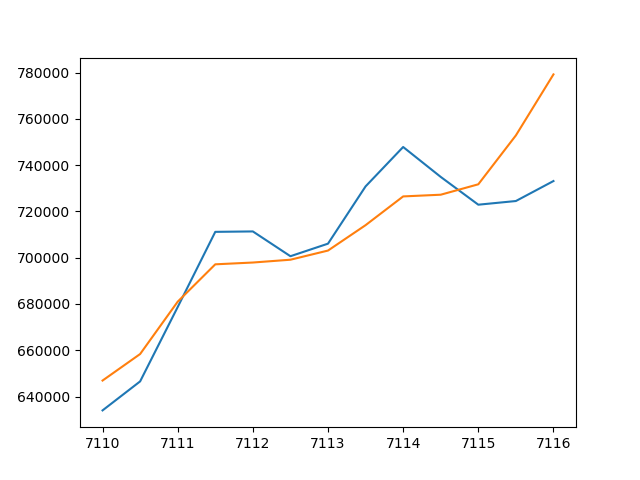

In [5]:
plt.figure()
plt.plot(Energy_set, GS)
plt.plot(Energy_set, ES)
plt.show()

In [12]:
pgroup = 'p21992'
Loaddir_name = 'All_shots'

twodiodes = True

runlist2 = np.arange(99, 103, 1)
runlist3 = np.arange(106, 111, 1)
runlist4 = np.arange(113, 116, 1)
runlist = np.concatenate((runlist2, runlist3, runlist4))

runlist = [97]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist, twodiodes)

globals().update(data)
print (runlist)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(pump_1)))

[97]
1 scan(s), 12582 total on/off shots


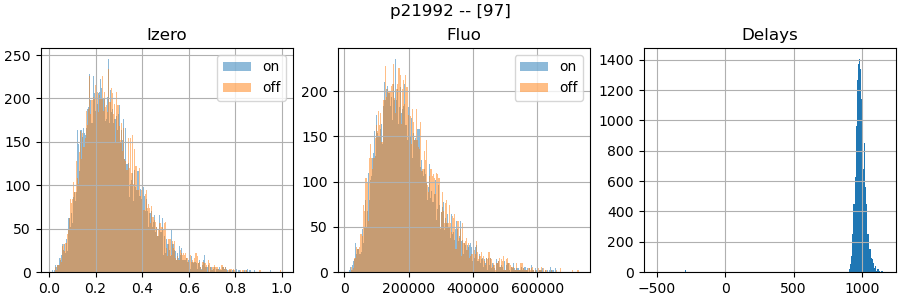

In [13]:
pump_1       = np.asarray(pump_1)
unpump_1     = np.asarray(unpump_1)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
energy       = np.asarray(energy)
Delays_corr  = np.asarray(Delays_corr)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
fig.suptitle(pgroup + ' -- ' + str(runlist))
ax1.title.set_text('Izero')
ax1.hist(Izero_pump, bins = 200, alpha=0.5, label = 'on')
ax1.hist(Izero_unpump, bins = 200, alpha=0.5, label = 'off')
ax1.legend(loc='best')
ax2.title.set_text('Fluo')
ax2.hist(pump_1, bins = 200, alpha=0.5, label = 'on')
ax2.hist(unpump_1, bins = 200, alpha=0.5, label = 'off')
ax2.legend(loc='best')
ax3.title.set_text('Delays')
ax3.hist(Delays_corr, bins = 200)
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

In [14]:
scan

SFScanInfo("/sf/alvra/data/p21992/raw/run0097-MbCO_XANES_500fs/meta/scan.json"): 13 steps

In [44]:
quantile = 0.7

variable_bins = False
withTT = True

numbins = 100

binsize = 10
min_delay = -750
max_delay = 1750

################################################################
binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
pp_TT = np.zeros(len(bin_centres))
err_pp = np.zeros(len(bin_centres))

totalshots = len(pump_1)
howmany_before = []
howmany = []
for i in range(len(bin_centres)):
    cond1 = Delays_corr >= binList[i]
    cond2 = Delays_corr < binList[i+1]

    idx = np.where(cond1*cond2)[0]
    Delay_fs_TT[i] = np.average(Delays_corr[idx])

    Fluo_pump_in_bin       = pump_1[idx]
    Fluo_unpump_in_bin     = unpump_1[idx]
    
    IzeroFEL_pump_in_bin   = Izero_pump[idx]
    IzeroFEL_unpump_in_bin = Izero_unpump[idx]
    
    howmany_before.append(len(Delays_corr[idx]))

    Fluo_pump_in_bin_filter, Fluo_unpump_in_bin_filter, IzeroFEL_pump_in_bin_filter, IzeroFEL_unpump_in_bin_filter = \
    correlation_filter(Fluo_pump_in_bin, Fluo_unpump_in_bin, IzeroFEL_pump_in_bin, IzeroFEL_unpump_in_bin, quantile)
    
    howmany.append(len(Fluo_pump_in_bin_filter))
    
    Fluo_pump_in_bin_filter   = Fluo_pump_in_bin_filter / IzeroFEL_pump_in_bin_filter
    Fluo_unpump_in_bin_filter = Fluo_unpump_in_bin_filter / IzeroFEL_unpump_in_bin_filter
    
    #Pump_probe_shot = Fluo_pump_in_bin_filter - Fluo_unpump_in_bin_filter
    Pump_probe_shot = np.log10(Fluo_pump_in_bin_filter / Fluo_unpump_in_bin_filter)

    pp_TT[i]  = np.nanmean(Pump_probe_shot)
    err_pp[i] = np.nanstd(Pump_probe_shot)/np.sqrt(len(Pump_probe_shot))

print ('{} shots out of {} survived (total shots: {})'.format(np.sum(howmany), np.sum(howmany_before), totalshots))

139106 shots out of 285540 survived (total shots: 320444)


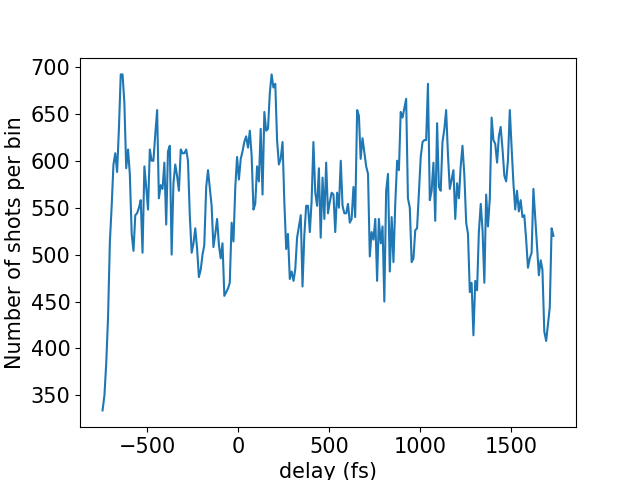

In [45]:
plt.figure()
plt.plot(Delay_fs_TT, howmany)
plt.xlabel('delay (fs)')
plt.ylabel('Number of shots per bin')
plt.show()

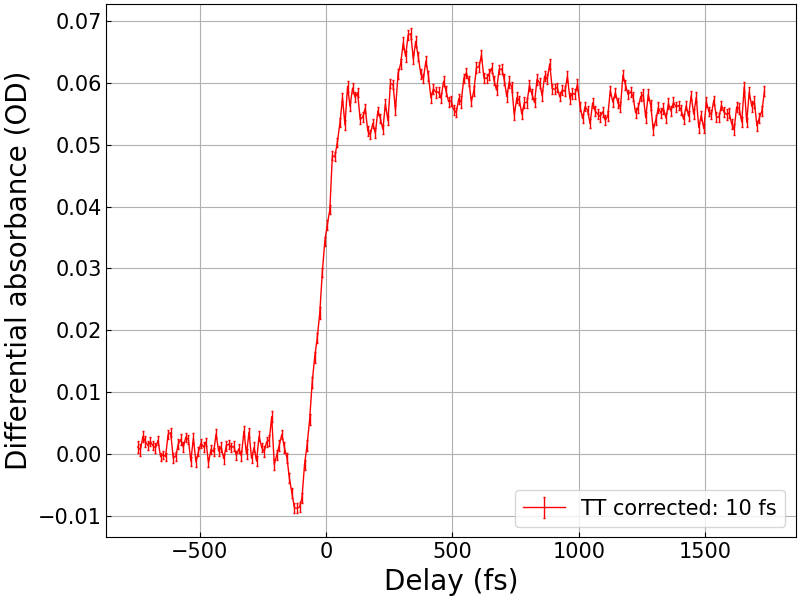

In [41]:
fitflag = False

fig, ax = plt.subplots(constrained_layout=True, figsize=(8,6))
plt.rcParams.update({'font.size': 15})
#plt.suptitle(runlist)
#plt.title('E = 7111.7 eV')
#units = scan.parameters['units'][0]
#label = scan.parameters['name'][0]

plt.tick_params(direction='in')

#plt.scatter(Delays_corr_scan, Pump_probe_scan, s=0.2, color = 'lightblue')

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected: {} fs'.format(binsize))

# plt.plot(Delay_fs_TT, pp_TT, 
#               lw=1,color='red',label='TT corrected: {} fs'.format(binsize))

# plt.xlabel("{} ({})".format(label, units))
# plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    #fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,-80)

    p0 = [-100, 100, 0, 200, 0]
    popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    t0_fs = popt[0]
    width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    # fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    # pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    # t0_fs = fit.popt[0]
    # width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))
    print("t0 = {:.4f} fs".format(t0_fs))

#plt.xlim(min_delay, max_delay)
plt.grid()
#plt.axvline(t0_fs)
#plt.tight_layout()
plt.ylabel('Differential absorbance (OD)', fontsize=20)
plt.xlabel('Delay (fs)', fontsize=20)
plt.show()

PNG_dir = '/sf/alvra/data/p21992/work/PNG/'
os.makedirs(PNG_dir, exist_ok=True)
plt.savefig(PNG_dir+'FePhen_XANES_kinetics.png')

In [198]:
pgroup = 'p21992'
Loaddir_name = 'All_shots'

runlist1 = np.arange(85, 90, 1)
runlist2 = np.arange(85, 90, 1)

runlist2 = np.arange(99, 103, 1)
runlist3 = np.arange(106, 111, 1)
runlist4 = np.arange(113, 116, 1)

runlist = np.concatenate((runlist1, runlist2, runlist3, runlist4))

runlist = np.setdiff1d(runlist, [110])

twodiodes = True

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

t0_loop = []

for run in runlist:
    print (run)
    data = {}
    globals().update(data)
    
    data, titlestring_stack = load_reduced_data(pgroup, Loaddir, [run], twodiodes)
    
    globals().update(data)

    pump_1       = np.asarray(pump_1)
    unpump_1     = np.asarray(unpump_1)
    Izero_pump   = np.asarray(Izero_pump)
    Izero_unpump = np.asarray(Izero_unpump)
    Delays_stage = np.asarray(Delays_stage)
    arrTimes     = np.asarray(arrTimes)
    energy       = np.asarray(energy)
    Delays_corr  = np.asarray(Delays_corr)

    quantile = 0.7

    variable_bins = False
    withTT = True
    
    numbins = 100
    
    binsize = 5
    min_delay = -200
    max_delay = 500
    
    ################################################################
    binList = np.arange(min_delay, max_delay, binsize)
    bin_centres = (binList[:-1] + binList[1:])/2
    
    Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
    pp_TT = np.zeros(len(bin_centres))
    err_pp = np.zeros(len(bin_centres))
    
    totalshots = len(pump_1)
    howmany_before = []
    howmany = []
    for i in range(len(bin_centres)):
        cond1 = Delays_corr >= binList[i]
        cond2 = Delays_corr < binList[i+1]
    
        idx = np.where(cond1*cond2)[0]
        Delay_fs_TT[i] = np.average(Delays_corr[idx])
    
        Fluo_pump_in_bin       = pump_1[idx]
        Fluo_unpump_in_bin     = unpump_1[idx]
        4659
        IzeroFEL_pump_in_bin   = Izero_pump[idx]
        IzeroFEL_unpump_in_bin = Izero_unpump[idx]
        
        howmany_before.append(len(Delays_corr[idx]))
    
        Fluo_pump_in_bin_filter, Fluo_unpump_in_bin_filter, IzeroFEL_pump_in_bin_filter, IzeroFEL_unpump_in_bin_filter = \
        correlation_filter(Fluo_pump_in_bin, Fluo_unpump_in_bin, IzeroFEL_pump_in_bin, IzeroFEL_unpump_in_bin, quantile)
        
        howmany.append(len(Fluo_pump_in_bin_filter))
        
        Fluo_pump_in_bin_filter   = Fluo_pump_in_bin_filter / IzeroFEL_pump_in_bin_filter
        Fluo_unpump_in_bin_filter = Fluo_unpump_in_bin_filter / IzeroFEL_unpump_in_bin_filter
        
        Pump_probe_shot = Fluo_pump_in_bin_filter - Fluo_unpump_in_bin_filter
        #Pump_probe_shot = np.log10(Fluo_pump_in_bin_filter / Fluo_unpump_in_bin_filter)
    
        pp_TT[i]  = np.nanmean(Pump_probe_shot)
        err_pp[i] = np.nanstd(Pump_probe_shot)/np.sqrt(len(Pump_probe_shot))
    
    print ('{} shots out of {} survived (total shots: {})'.format(np.sum(howmany), np.sum(howmany_before), totalshots))

    p0 = [-80, 100, 0, 200, 0]
    popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    t0_fs = popt[0]
    
    t0_loop.append(t0_fs)
    


85
26690 shots out of 54654 survived (total shots: 79706)
86
25510 shots out of 52610 survived (total shots: 79910)
87
25462 shots out of 52882 survived (total shots: 79978)
88
25226 shots out of 52368 survived (total shots: 79588)
89
25798 shots out of 53190 survived (total shots: 79480)
99
26614 shots out of 54708 survived (total shots: 99406)
100
26802 shots out of 54964 survived (total shots: 99282)
101
25760 shots out of 52756 survived (total shots: 99242)
102
26724 shots out of 54712 survived (total shots: 99502)
106
24480 shots out of 50570 survived (total shots: 97664)
107
25768 shots out of 52976 survived (total shots: 98552)
108
25704 shots out of 52900 survived (total shots: 99098)
109
26742 shots out of 55222 survived (total shots: 98614)
113
26252 shots out of 53736 survived (total shots: 98944)
114
25586 shots out of 52662 survived (total shots: 98872)
115
25530 shots out of 52542 survived (total shots: 99048)


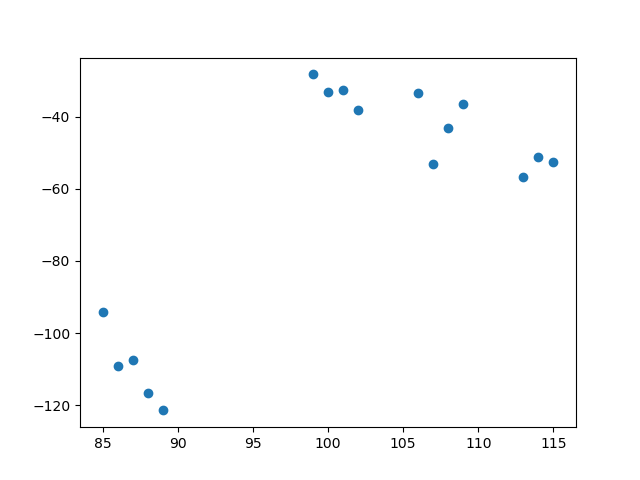

In [200]:
plt.figure()
plt.scatter(runlist, t0_loop)
plt.show()

82
(142,) (142,)


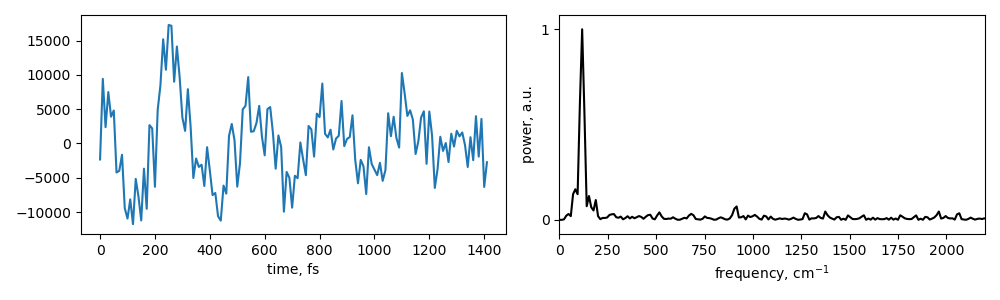

In [17]:
chosen_point = 70
index_point = np.int(np.argwhere(Delay_fs_TT > chosen_point)[0])
print (index_point)

transient = pp_TT[index_point:]
x = Delay_fs_TT[index_point:]
pp_fit = pp_fit[index_point:]

print(np.shape(transient), np.shape(x))
fitoutput = np.poly1d(np.polyfit(x, transient, 3))
pows = fitoutput(x)
transient2 = transient-pows
#transient2 = transient-pp_fit

                
vals = np.hstack((transient2, np.zeros_like(transient2))) # pad
power = np.abs(np.fft.fft(vals))**2
frequencies = np.arange(0,0.999999999,1/len(vals))*16678*(2/binsize)

plt.figure(figsize=(10,3))
#plt.suptitle(titlestring_stack)
plt.subplot(121)
#plt.plot(np.arange(0, binsize*len(transient), binsize), transient)
plt.plot(np.arange(0, binsize*len(transient), binsize), transient2, '-')
plt.xlabel('time, fs')

plt.subplot(122)
plt.plot(frequencies,power/np.max(power), '-', color='black')
plt.xlim(0,2200)
plt.xlabel('frequency, cm$^{-1}$')
plt.ylabel('power, a.u.')
plt.yticks([0,1])
plt.ylim(-0.075, 1.075)
#plt.vlines(1647, -0.1, 1.1, color='lightgrey', linestyle='dashed')
plt.tight_layout()

plt.show()

<a id='TT'></a>
## with TT

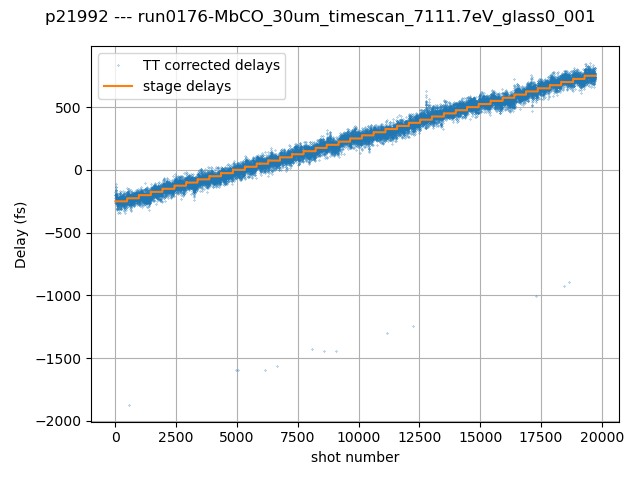

In [10]:
title=""
if Two_diodes:
    Pump_probe_scan  = Pump_probe_scan + Pump_probe_scan2
    Delays_corr_scan = Delays_corr_scan + Delays_corr_scan2
    Delays_fs_scan   = Delays_fs_scan + Delays_fs_scan2
    title = "Two diodes"

plt.figure()
plt.suptitle(titlestring)
plt.title(title)
plt.plot(Delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.tight_layout()
plt.show()

### Choose parameters and rebin

(19730,) (19730,) (19730,)
Rebin with 100 bins of 10 fs
Rebin TT corrected delays


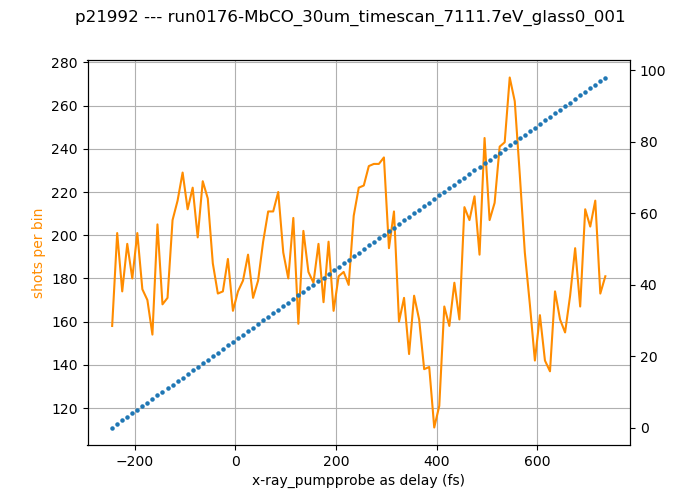

In [11]:
variable_bins = False
withTT = True

numbins = 100

binsize = 10
min_delay = -250
max_delay = 750

######################################################################################

Delay_fs_TT, pp_TT, pp_std, err_pp, count, binsize = rebin_XANES(Pump_probe_scan, Delays_corr_scan, Delays_fs_scan, 
                                                                 variable_bins, withTT, numbins, binsize, min_delay, max_delay)

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(Delay_fs_TT), 1)
ax1.plot(Delay_fs_TT, np.array(count), color = 'darkorange')
ax2.scatter(Delay_fs_TT, delayrange, s = 5)

ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()

Width = 50.4930 fs
t0 = 83.9263 fs


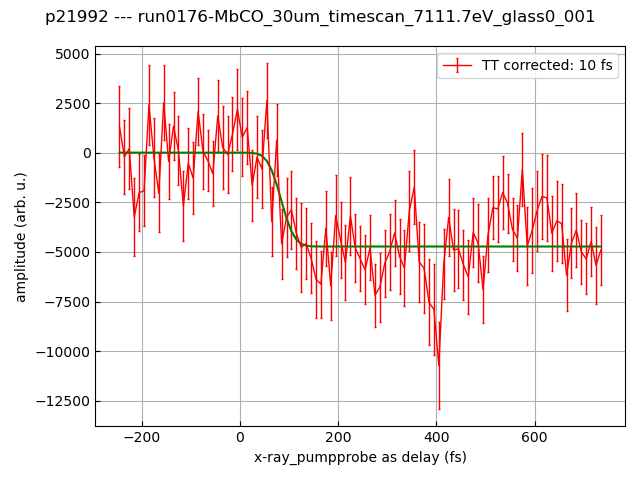

In [12]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle(titlestring)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

#plt.scatter(Delays_corr_scan, Pump_probe_scan, s=0.2, color = 'lightblue')

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected: {} fs'.format(binsize))

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    #fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    #fit.p0 = better_p0(fit.p0, 4,100)
    fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))
    print("t0 = {:.4f} fs".format(t0_fs))

#plt.xlim(min_delay, max_delay)
plt.grid()
#plt.axvline(t0_fs)
plt.tight_layout()
plt.show()

<a id='no_TT'></a>
## without TT

Scan is done with the stage in fs


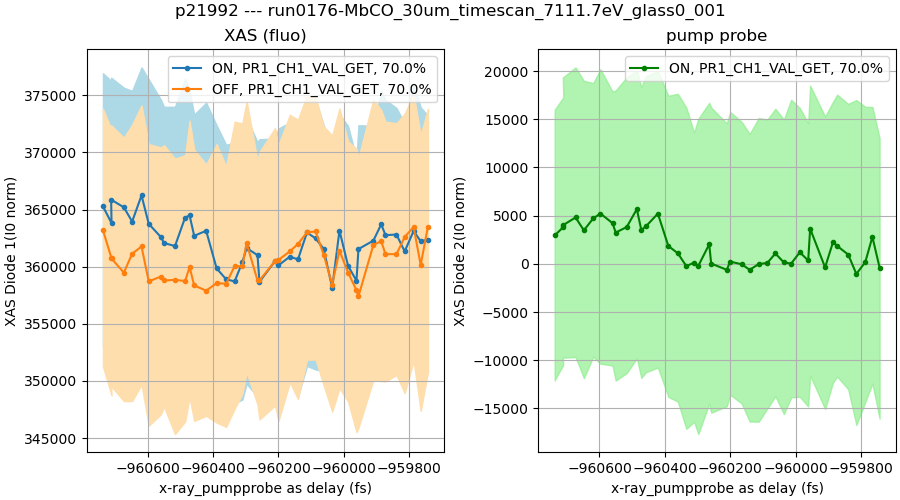

In [8]:
if Two_diodes:
    XAS1_pump_probe, XAS2_pump_probe, Delay_fs = Plot_2diodes_3figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=True)
    Delay_fs, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring, scan, data, timescan=True)
else:
    XAS1_pump_probe, Delay_fs = Plot_1diode(titlestring, scan, data, 
                                            quantile_corr, detector_XAS_1, timescan=True)

In [21]:
XAS2fit = XAS1_pump_probe
legend = detector_XAS_1
if Two_diodes:
    XAS2fit = ave_pp1
    legend = "Averaged"
    
###################################################

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS2fit)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_fs,XAS2fit)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
width_fs = fit.popt[2]

print ("Width = {:.3f} {}".format(abs(width_fs), units))
print ("Position t0 = {:.3f} {}".format(t0_fs, units))

Width = 31.791 fs
Position t0 = -961763.327 fs


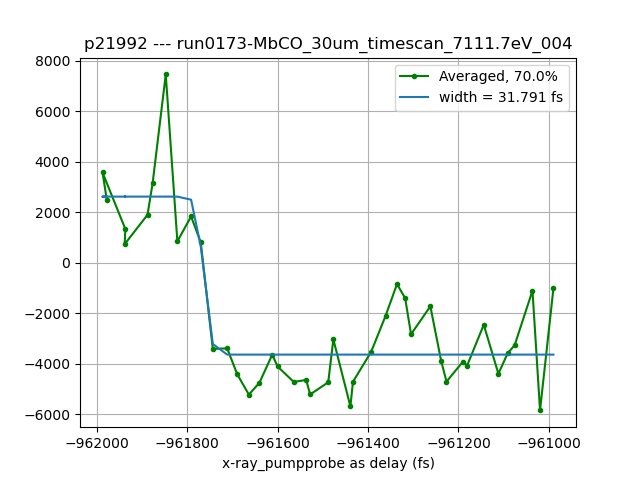

In [22]:
plt.figure()
units = scan.parameters['units'][0]
label = scan.parameters['name'][0]
plt.title(titlestring)
plt.plot(Delay_fs, XAS2fit, label='{}, {}%'.format(legend, quantile_corr*100),color='green',marker='.')
plt.plot(Delay_fs, pp_fit, label = 'width = {:.3f} fs'.format(abs(width_fs)))
plt.legend(loc='best')
plt.xlabel("{} ({})".format(label, units))
plt.grid()
plt.show()

<a id='multiple_runs'></a>
## Reduce multiple runs

In [264]:
pgroup = 'p21992'

runlist = np.arange(119,124)

#####################################
jsonlist = []
for run in runlist:
    jsonlist.append(glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0])
jsonlist

['/sf/alvra/data/p21992/raw/run0119-MbCO_timescan_7111.7eV_001/meta/scan.json',
 '/sf/alvra/data/p21992/raw/run0120-MbCO_timescan_7111.7eV_002/meta/scan.json',
 '/sf/alvra/data/p21992/raw/run0121-MbCO_timescan_7111.7eV_003/meta/scan.json',
 '/sf/alvra/data/p21992/raw/run0122-MbCO_timescan_7111.7eV_004/meta/scan.json',
 '/sf/alvra/data/p21992/raw/run0123-MbCO_timescan_7111.7eV_005/meta/scan.json']

In [265]:
channel_diode_1 = 'SARES12-GES1:PR1_CH1_VAL_GET'
channel_diode_2 = 'SARES12-GES1:PR1_CH2_VAL_GET'

In [266]:
with_TT    = True
Two_diodes = True

reducedir='../Reduced_data/Timescans/'

saveflag=True

quantile_corr = 0.5

channel_delay_motor = channel_delay_beckhoff
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

TT = TT_PSEN126

#######################################################################################################

for jsonfile in jsonlist:
    
    from sfdata import SFScanInfo
    scan = SFScanInfo(jsonfile)
    scan = remove_JF_from_scan(scan)
    
    run_name = jsonfile.split('/')[-3]

    LoadTimescansXANES(with_TT, Two_diodes, scan, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr, saveflag, reducedir, run_name)


Processing: run0123-MbCO_timescan_7111.7eV_005
Step 51 of 51: Processing acq0051

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1986 / 2003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1986 / 2003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1986 / 2003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1986 / 2003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1986 / 2003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1986 / 2003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET             2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET             2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY                2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAT-L-BECKBS:PR1_CH1_VAL_GET           2001 / 2003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole d